# Analysing the effect of Circuit Breaker measures on HDB carpark availability

*Madeline Lim, July 2020*

## Introduction

This piece of analysis is inspired by a post by the NUS Urban Analytics Lab, [Singapore's urban data affirms the compliance with the Circuit Breaker measures](https://ual.sg/post/2020/04/12/singapores-urban-data-affirms-the-compliance-with-the-circuit-breaker-measures/), which analysed various urban data trends to determine the impact of the Circuit Breaker (CB) imposed in Singapore in April 2020. 

The analysis included car traffic trends, with HDB carpark availability used as a proxy for car traffic. 

In this project, we aim to replicate the HDB carpark availabilty analysis, as well as uncover any longer-term trends during the post-CB period in phase 1 and 2, since the original post was published in April.

<img src="https://ual.sg/post/2020/04/12/singapores-urban-data-affirms-the-compliance-with-the-circuit-breaker-measures/carpark_availability_panels_hu68363be4eb0f2a7d65c49f491202cb0b_353679_2000x2000_fit_lanczos_2.png" width=500 />
<p style="text-align: center;"><i>Source: NUS Urban Analytics Lab</i></p>

## Data sources

Our primary data source is the [Carpark Availability](https://data.gov.sg/dataset/carpark-availability) dataset from Data.gov.sg.

Additional information on individual carparks can be found [here](https://data.gov.sg/dataset/hdb-carpark-information), however for simplicity's sake we will aggregate carpark data across all carparks, and analyse these trends over time.

## Exploring real-time data

Before jumping into analysing historical trends, let's explore what carpark data is available for us to analyse. We'll first take a look at the real-time carpark data information.

In [104]:
import datetime as dt
import json
import numpy as np
import pandas as pd
import requests
import seaborn as sns

In [9]:
url = 'https://api.data.gov.sg/v1/transport/carpark-availability'
time = dt.datetime.now().isoformat()
payload = {'date_time': time}

r = requests.get(url, params = payload).json()

In [226]:
results = r['items']

carparks = pd.json_normalize(results, ['carpark_data', 'carpark_info'], ['timestamp', ['carpark_data', 'carpark_number']])
carparks['total_lots'] = carparks['total_lots'].astype(int)
carparks['lots_available'] = carparks['lots_available'].astype(int)

carparks

,total_lots,lot_type,lots_available,timestamp,carpark_data.carpark_number
0,91,C,88,2020-07-10T11:59:27+08:00,HE12
1,583,C,154,2020-07-10T11:59:27+08:00,HLM
2,322,C,102,2020-07-10T11:59:27+08:00,RHM
3,97,C,19,2020-07-10T11:59:27+08:00,BM29
4,96,C,0,2020-07-10T11:59:27+08:00,Q81
...,...,...,...,...,...
2216,45,Y,34,2020-07-10T11:59:27+08:00,ACM
2217,10,H,0,2020-07-10T11:59:27+08:00,ACM
2218,81,C,4,2020-07-10T11:59:27+08:00,CKT2
2219,260,C,260,2020-07-10T11:59:27+08:00,TM54


In [227]:
number_carparks = carparks['carpark_data.carpark_number'].nunique()
total_lots = carparks['total_lots'].sum()
lots_available = carparks['lots_available'].sum()

print('Timestamp:', time)
print('Number of HDB carparks:', number_carparks)
print('Total number of parking lots:', total_lots)
print('Number of available parking lots:', lots_available)
print('Occupancy:', ((total_lots - lots_available) * 100/ total_lots).round(2), '%')

Timestamp: 2020-07-10T12:00:05.588869
Number of HDB carparks: 1905
Total number of parking lots: 719016
Number of available parking lots: 350428
Occupancy: 51.26 %


We can see that the dataset returns data for 1,905 unique HDB carparks.

As of 10 July 2020, at 12pm, of ~72,000 parking lots across all HDB carparks, there are ~35,000 available parking lots. This translates to an occupancy rate of 51%.

## Setting up analysis for historical data

Let's now set up the relevant code for us to take a look at historical carpark data over the past few months. 

We'll use the function `create_df` to create a dataframe with hourly timestamps in each row. To decrease the number of API calls made, we will only look at the time period between 6am to 9pm each day.

Let's first take a look at data from the week starting 6 April (i.e. 6 to 12 April) - the week that the Circuit Breaker measures took effect. 

In [107]:
def create_df(start_date, end_date):
    df = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='1H', closed='left')})
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.strftime('%A')
    df = df[df.hour > 5]
    df = df[df.hour < 22]
    df = df.reset_index(drop = True)
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%dT%H:%M%:%S')
    return df

In [108]:
apr6_apr12 = create_df('2020-04-06', '2020-04-13')

apr6_apr12

,date,hour,day
0,2020-04-06T06:00:00,6,Monday
1,2020-04-06T07:00:00,7,Monday
2,2020-04-06T08:00:00,8,Monday
3,2020-04-06T09:00:00,9,Monday
4,2020-04-06T10:00:00,10,Monday
...,...,...,...
107,2020-04-12T17:00:00,17,Sunday
108,2020-04-12T18:00:00,18,Sunday
109,2020-04-12T19:00:00,19,Sunday
110,2020-04-12T20:00:00,20,Sunday


We then create the fuction `extract_data`, which takes the timestamp as an input and returns the **total number of lots** and the **number of available lots**. This is an aggregated value across all HDB carparks.

In [65]:
def extract_data(time):
    url = 'https://api.data.gov.sg/v1/transport/carpark-availability'
    payload = {'date_time': time}
    r = requests.get(url, params = payload).json()
    results = r['items']

    carparks = pd.json_normalize(results, ['carpark_data', 'carpark_info'])
    carparks['total_lots'] = carparks['total_lots'].astype(int)
    carparks['lots_available'] = carparks['lots_available'].astype(int)
    
    values = {}
    values['total_lots'] = carparks['total_lots'].sum()
    values['lots_available'] = carparks['lots_available'].sum()
    
    return values

Lastly, we use the function `fill_data` to loop through the dataframe, to apply the `extract_data` function to each row in order to get the required outputs.

In [109]:
def fill_data(dataset):
    for i in range(len(dataset)): 
        input_time = dataset.loc[i, 'date']
        output = extract_data(input_time)
        dataset.loc[i, 'total_lots'] = output['total_lots']
        dataset.loc[i, 'lots_available'] = output['lots_available']
        dataset['occupancy'] = (dataset['total_lots'] - dataset['lots_available']) / dataset['total_lots']
    return dataset

In [110]:
apr6_apr12 = fill_data(apr6_apr12)

apr6_apr12

,date,hour,day,total_lots,lots_available,occupancy
0,2020-04-06T06:00:00,6,Monday,716951.0,330005.0,0.539711
1,2020-04-06T07:00:00,7,Monday,717106.0,378000.0,0.472881
2,2020-04-06T08:00:00,8,Monday,716951.0,422538.0,0.410646
3,2020-04-06T09:00:00,9,Monday,716951.0,456378.0,0.363446
4,2020-04-06T10:00:00,10,Monday,716960.0,471746.0,0.342019
...,...,...,...,...,...,...
107,2020-04-12T17:00:00,17,Sunday,717374.0,349262.0,0.513138
108,2020-04-12T18:00:00,18,Sunday,717374.0,349413.0,0.512928
109,2020-04-12T19:00:00,19,Sunday,717374.0,346746.0,0.516645
110,2020-04-12T20:00:00,20,Sunday,717374.0,343921.0,0.520583


Finally, we plot the results using a heatmap. We create a function `plot_heatmap` that returns a cleaned, formatted heatmap of the data.

In [149]:
def plot_heatmap(dataset, date):
    heatmap_data = pd.pivot_table(dataset, values='occupancy', index=['hour'], columns='day')
    column_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(column_order, axis=1)

    ax = sns.heatmap(heatmap_data, vmin = 0.3, vmax = 0.6, linewidths = 0.5)
    ax.tick_params(left = False, bottom = False)
    ax.set_title("HDB carpark occupancy rate \n {}".format(date))
    ax.set_xlabel("Day of week")
    ax.set_ylabel("Hour of day")
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 0)
    
    return ax

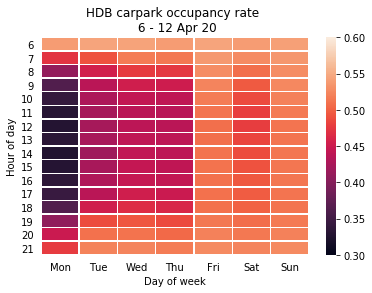

In [150]:
plot_heatmap(apr6_apr12, "6 - 12 Apr 20")

From the heatmap, we can see that the results for the week of 6 April are similar to the NUS UAL graphic, where a significant change in occupancy rate is seen from Tuesday onwards, when the Circuit Breaker was imposed.

## Exploring historical data

We're now ready to explore historical trends. To recap, here's a timeline of Singapore's Circuit Breaker:

| Start date | End date | Phase |
| --- | --- | --- |
| 7 Apr (Tue) | 1 Jun (Mon) | Circuit Breaker |
| 2 Jun (Tue) | 18 Jun (Thu) | Phase 1 |
| 19 Jun (Fri) | Present | Phase 2 |

### Pre-COVID

We'll use carpark data from one year ago as a proxy for pre-COVID trends. Specifically, the data from 1 to 7 April 2019 was used. 

The minimum occupancy reached in that week was 31% on a weekday, while minimum occupancy on Saturday reached 41%.

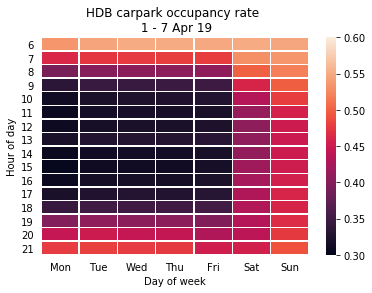

In [172]:
# 1 Apr 2019 to 7 Apr 2019

apr1_apr7 = create_df('2019-04-01', '2019-04-08')
apr1_apr7 = fill_data(apr1_apr7)
plot_heatmap(apr1_apr7, "1 - 7 Apr 19")

In [195]:
print("Minimum occupancy:", apr1_apr7['occupancy'].min())
print("Minimum occupancy (weekend):", apr1_apr7[apr1_apr7['day'].isin(['Saturday', 'Sunday'])]['occupancy'].min())

Minimum occupancy: 0.3051239427400045
Minimum occupancy (weekend): 0.40717127923224217


### Pre-Circuit Breaker

Prior to the official Circuit Breaker being announced, Singaporeans were already making changes to their behaviour, including working from home and reducing the amount of time spent outdoors.

For this, we will take a look at data one week before the Circuit Breaker - from 30 March to 5 April.

Minimum occupancy on Monday was at 31%, however, by Friday, 3 April, the day the Circuit Breaker measures were announced, this had increased to 34%. Minimum occupancy over the weekend also increased to 42%.

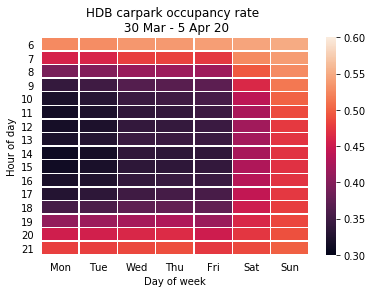

In [176]:
# 30 Mar to 5 Apr

mar30_apr5 = create_df('2020-03-30', '2020-04-06')
mar30_apr5 = fill_data(mar30_apr5)
plot_heatmap(mar30_apr5, "30 Mar - 5 Apr 20")

In [196]:
print("Minimum occupancy (Mon):", mar30_apr5[mar30_apr5['day'] == "Monday"]['occupancy'].min())
print("Minimum occupancy (Fri):", mar30_apr5[mar30_apr5['day'] == "Friday"]['occupancy'].min())
print("Minimum occupancy (weekend):", mar30_apr5[mar30_apr5['day'].isin(['Saturday', 'Sunday'])]['occupancy'].min())

Minimum occupancy (Mon): 0.3105801334104707
Minimum occupancy (Fri): 0.338541514355223
Minimum occupancy (weekend): 0.42004060704468166


### Circuit Breaker

As seen in the above analysis, there was a significant increase in occupancy rates between Monday and Tuesday, when the Circuit Breaker started in Singapore.

Excluding Monday (the day before the Circuit Breaker), minimum occupancy for the week rose to 42%. This figure rose further to 48% on the weekend.

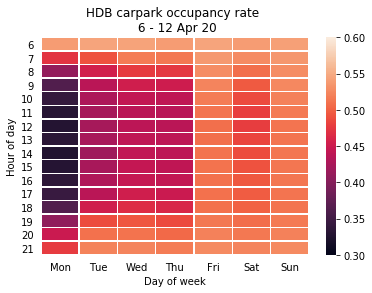

In [178]:
# 6 Apr to 12 Apr

plot_heatmap(apr6_apr12, "6 - 12 Apr 20")

In [197]:
print("Minimum occupancy (excluding Mon):", apr6_apr12[apr6_apr12['day'] != "Monday"]['occupancy'].min())
print("Minimum occupancy (weekend):", apr6_apr12[apr6_apr12['day'].isin(['Saturday', 'Sunday'])]['occupancy'].min())

Minimum occupancy (excluding Mon): 0.41910242910569695
Minimum occupancy (weekend): 0.4784535578012884


### Phase 1

The last day of the Circuit Breaker was on Monday, 1 June. Phase 1 began on Tuesday, 2 June. Minimum occupancy for the week fell to 38%.  The weekend figure also fell to 46%.

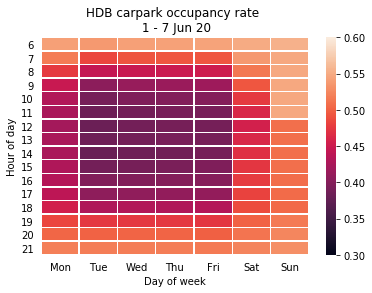

In [152]:
# 1 June to 7 June

jun1_jun7 = create_df('2020-06-01', '2020-06-08')
jun1_jun7 = fill_data(jun1_jun7)
plot_heatmap(jun1_jun7, "1 - 7 Jun 20")

In [198]:
print("Minimum occupancy:", jun1_jun7['occupancy'].min())
print("Minimum occupancy (weekend):", jun1_jun7[jun1_jun7['day'].isin(['Saturday', 'Sunday'])]['occupancy'].min())

Minimum occupancy: 0.3814642552408359
Minimum occupancy (weekend): 0.456896167309536


### Phase 2

Phase 2 finally began on Friday, 19 June. Minimum occupancy further fell on Friday to 37%. The weekend figure also fell to 44%.

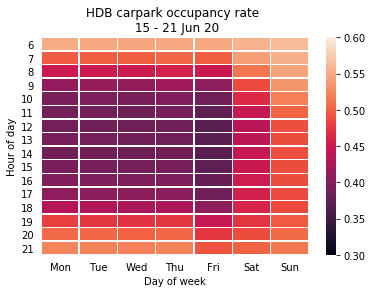

In [153]:
# 15 June to 21 June

jun15_jun21 = create_df('2020-06-15', '2020-06-22')
jun15_jun21 = fill_data(jun15_jun21)
plot_heatmap(jun15_jun21, "15 - 21 Jun 20")

In [199]:
print("Minimum occupancy:", jun15_jun21['occupancy'].min())
print("Minimum occupancy (weekend):", jun15_jun21[jun15_jun21['day'].isin(['Saturday', 'Sunday'])]['occupancy'].min())

Minimum occupancy: 0.3696153235886058
Minimum occupancy (weekend): 0.4381049279445046


### Current occupancy levels

Current occupancy rates are still substantially below pre-Circuit Breaker levels. The lowest occupancy for the week of 29 June to 5 July was 36%, while weekend minimum occupancy is at 43%.

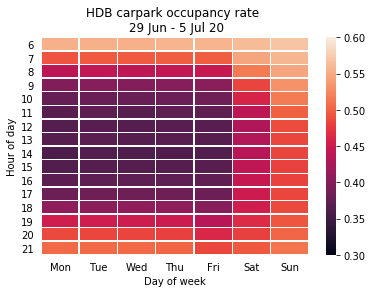

In [187]:
# 29 June to 5 July

jun29_jul5 = create_df('2020-06-29', '2020-07-6')
jun29_jul5 = fill_data(jun29_jul5)
plot_heatmap(jun29_jul5, "29 Jun - 5 Jul 20")

In [200]:
print("Minimum occupancy:", jun29_jul5['occupancy'].min())
print("Minimum occupancy (weekend):", jun29_jul5[jun29_jul5['day'].isin(['Saturday', 'Sunday'])]['occupancy'].min())

Minimum occupancy: 0.36031052927457824
Minimum occupancy (weekend): 0.43098846106182737


## Closing

The carpark data largely mirrors reported changes in behaviour as a result of the Circuit Breaker - occupancy at HDB carparks has significantly increased as a result of more people working from home instead of taking their cars out. 

As the country moves to each consecutive phase, there are incremental changes in the data that suggest that car movement is slowly trending back to normal pre-COVID levels. However, with the country still in phase 2 of reopening, these trends are a far cry from normal levels - only time can tell if or when things can go back to normal.